In [286]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv("data.csv")
data.info()

le = LabelEncoder()
le.fit(data['Label'])
data['Transformed Label'] = le.transform(data['Label'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013 entries, 0 to 3012
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3013 non-null   int64  
 1   Label       3013 non-null   object 
 2   Model       3013 non-null   object 
 3   Year        3013 non-null   int64  
 4   HP          3007 non-null   float64
 5   Min cost    3013 non-null   float64
 6   Max cost    3013 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 164.9+ KB


Выбросы

<Axes: >

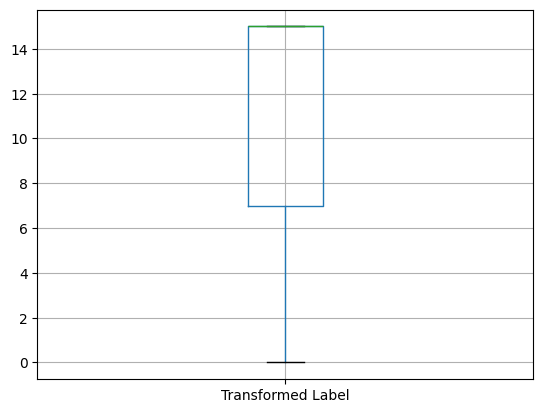

In [287]:
data.boxplot(column='Transformed Label')

<Axes: >

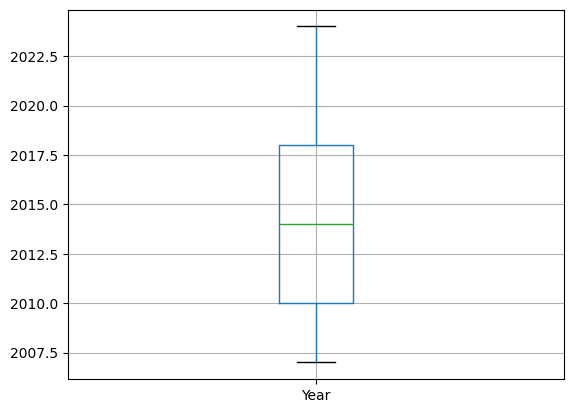

In [288]:
data.boxplot(column='Year')

<Axes: >

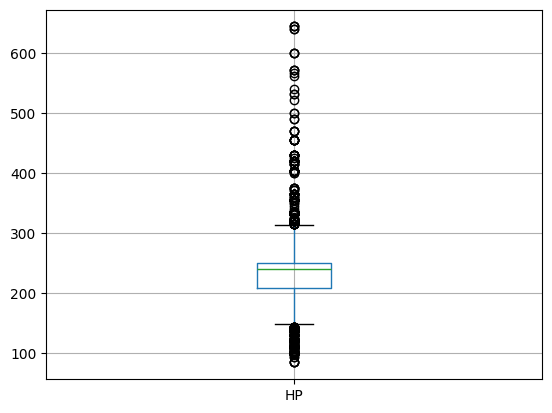

In [289]:
data.boxplot(column='HP')

<Axes: >

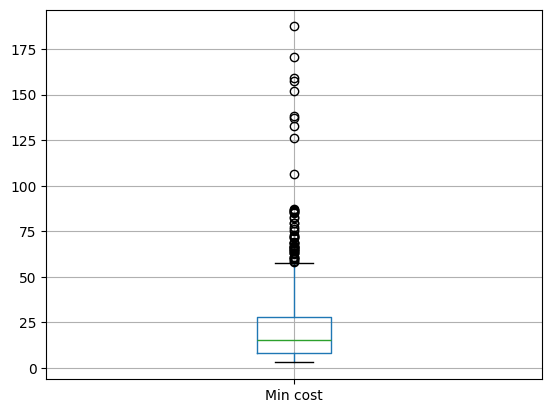

In [290]:
data.boxplot(column='Min cost')

<Axes: >

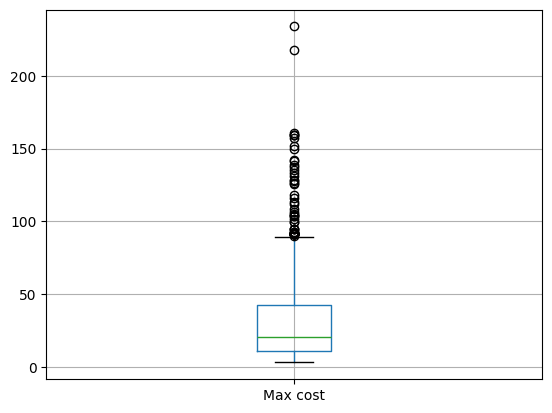

In [291]:
data.boxplot(column='Max cost')

Избавление от выбросов

In [292]:

for name in {'HP', 'Min cost', 'Max cost'}:
    Q1 = data[name].quantile(0.1)
    Q3 = data[name].quantile(0.9)
    IQR = Q3 - Q1
    data = data[(data[name] > Q1) & (data[name] < Q3)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1468 entries, 0 to 3012
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1468 non-null   int64  
 1   Label              1468 non-null   object 
 2   Model              1468 non-null   object 
 3   Year               1468 non-null   int64  
 4   HP                 1468 non-null   float64
 5   Min cost           1468 non-null   float64
 6   Max cost           1468 non-null   float64
 7   Transformed Label  1468 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 103.2+ KB


Показ результатов

<Axes: >

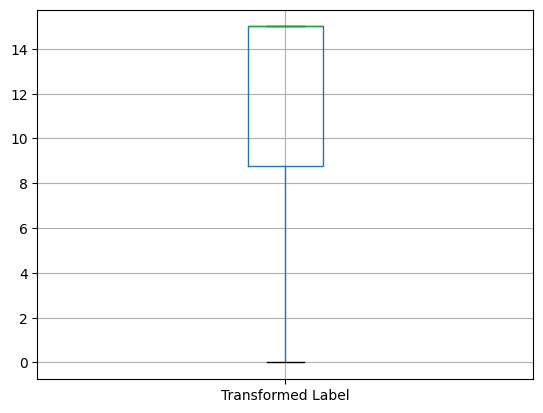

In [293]:
data.boxplot(column='Transformed Label')

<Axes: >

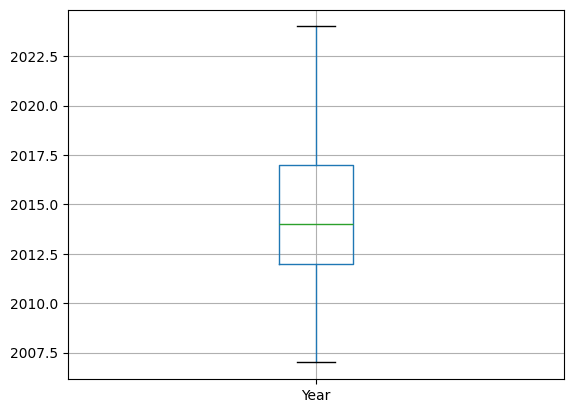

In [294]:
data.boxplot(column='Year')

<Axes: >

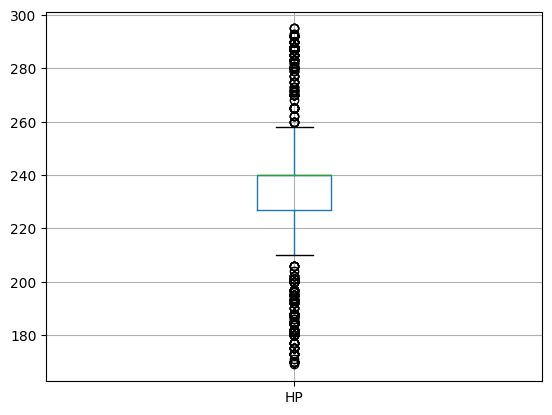

In [295]:
data.boxplot(column='HP')

<Axes: >

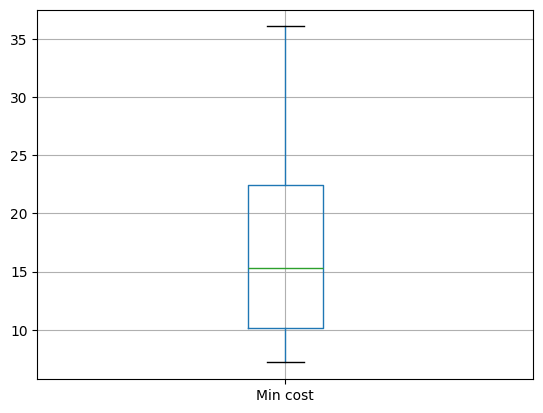

In [296]:
data.boxplot(column='Min cost')

<Axes: >

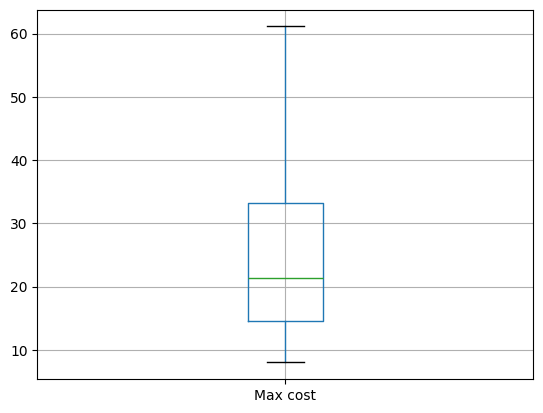

In [297]:
data.boxplot(column='Max cost')

In [298]:
def make_valid_dataset(x_train, y_train):
    x_real_train = []
    y_real_train = []
    for i in range(len(x_train)):
        if(not "nan" in str(x_train[i])):
            x_real_train.append(x_train[i])
            y_real_train.append(y_train[i])
    return x_real_train, y_real_train

In [299]:
X = data[['Transformed Label', 'HP', 'Min cost', 'Year']].values
y = data['Max cost'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/9, random_state=0)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train_scaler = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_real_valid, y_real_valid = make_valid_dataset(x_val, y_val)
x_real_test, y_real_test = make_valid_dataset(x_test, y_test)

x_real_train, y_real_train = make_valid_dataset(x_train, y_train)
x_train_scaler, y_real_train = make_valid_dataset(x_train_scaler, y_train)

Основной алгоритм предсказания

In [300]:
def predict(predictorCreator, num_of_steps=1000):
    min_e = 10000
    best_k = 1
    x_valid_to_draw = []
    y_valid_to_draw = []
    x_test_to_draw = []
    y_test_to_draw = []
    x_train_to_draw = []
    y_train_to_draw = []
    for k in range(1, num_of_steps):
        knn = predictorCreator(k)
        knn.fit(x_real_train, y_real_train)

        y_pred_val = knn.predict(x_real_valid)

        mse = mean_squared_error(y_real_valid, y_pred_val)
        x_valid_to_draw.append(k)
        y_valid_to_draw.append(mse)
        if mse < min_e:
            min_e = mse
            best_k = k
        
        y_pred_test = knn.predict(x_real_test)

        mse = mean_squared_error(y_real_test, y_pred_test)
        x_test_to_draw.append(k)
        y_test_to_draw.append(mse)
            
        y_pred_train = knn.predict(x_train_scaler)

        mse = mean_squared_error(y_real_train, y_pred_train)
        x_train_to_draw.append(k)
        y_train_to_draw.append(mse)
        
    return best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw

In [301]:
def draw(best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw, name):
    print('Лучшие k:', best_k, ' mse: ', min_e)
    plt.plot(x_valid_to_draw, y_valid_to_draw)
    plt.xlabel(name) 
    plt.ylabel('error')
    plt.title('valid')  
    plt.show() 

    plt.plot(x_test_to_draw, y_test_to_draw)
    plt.xlabel(name) 
    plt.ylabel('error')
    plt.title('test')  
    plt.show() 

    plt.plot(x_train_to_draw, y_train_to_draw)
    plt.xlabel(name) 
    plt.ylabel('error')
    plt.title('train')  
    plt.show() 

In [ ]:
Метод ближайших соседей

Лучшие k: 6  mse:  25.275611206727138


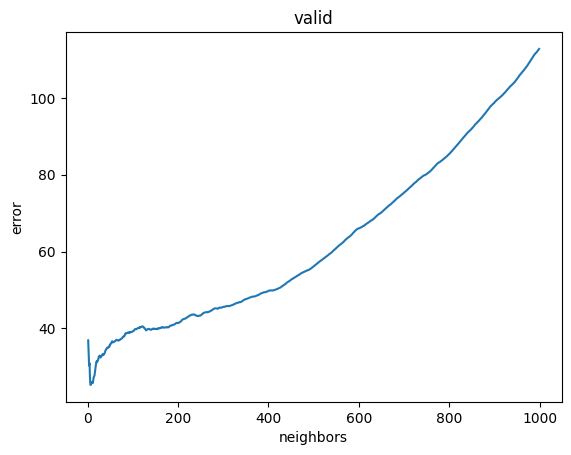

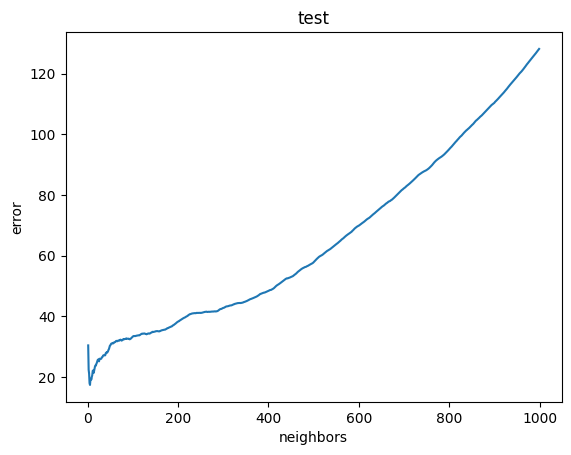

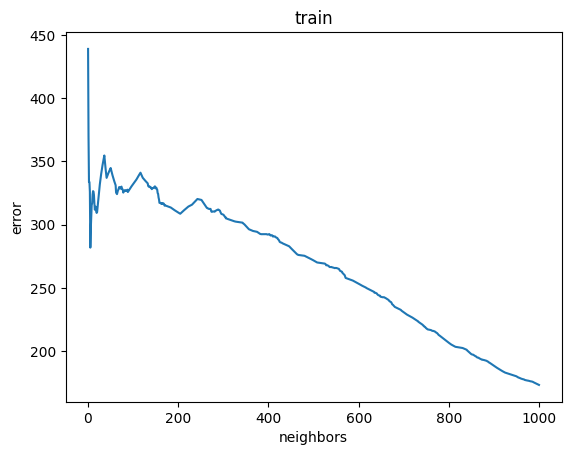

In [302]:
def knnCreator(k):
    return KNeighborsRegressor(n_neighbors=k)

best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw = predict(knnCreator)
draw(best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw, 'neighbors')

In [ ]:
Метод деревьев принятия решений

Лучшие k: 8  mse:  30.511701351792826


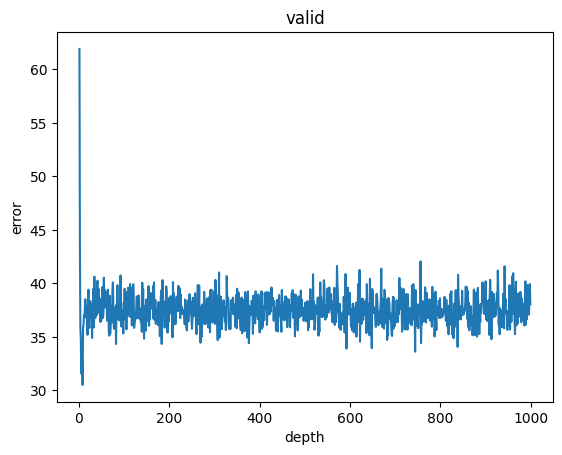

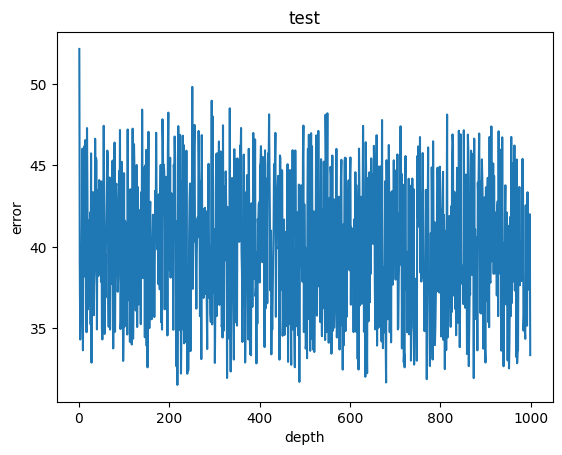

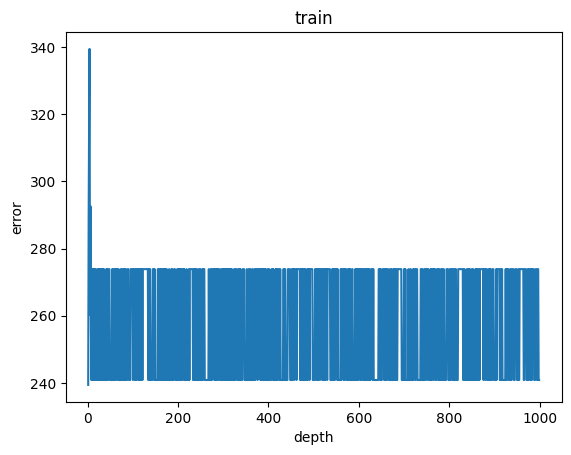

In [303]:
def dtcfCreator(k):
    return DecisionTreeRegressor(max_depth=k)
best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw = predict(dtcfCreator)
draw(best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw, 'depth')

In [ ]:
Метод линейной регрессии

Лучшие k: 1  mse:  37.01956067623659


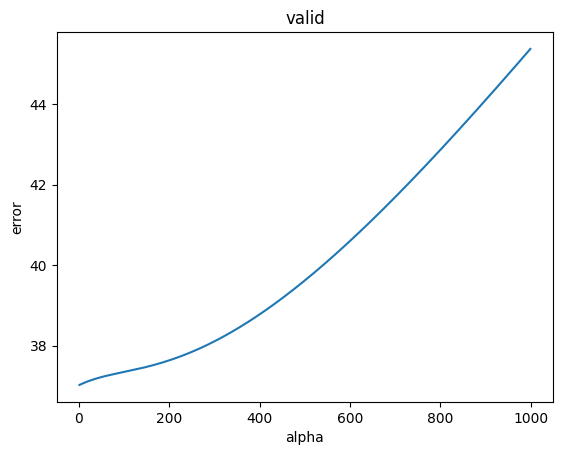

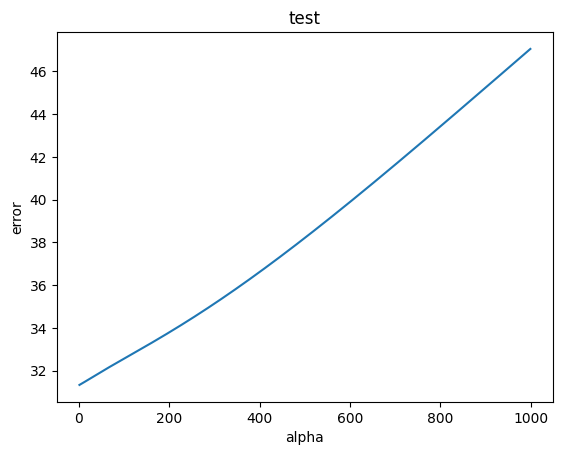

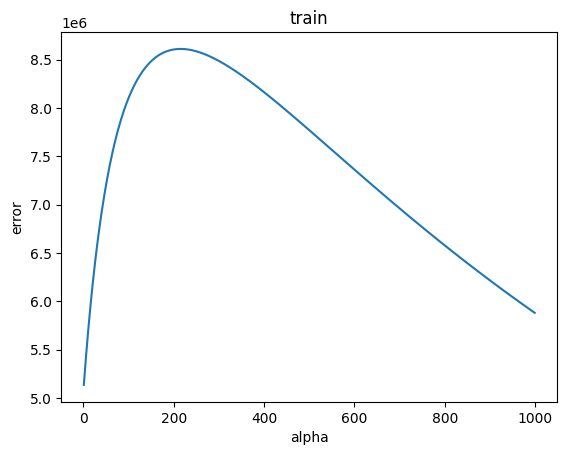

In [304]:
def linRegCreator(k):
    return Ridge(alpha=k)
best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw = predict(linRegCreator)
draw(best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw, 'alpha')

In [ ]:
Метод ансамбля

Лучшие k: 18  mse:  23.95579208799446


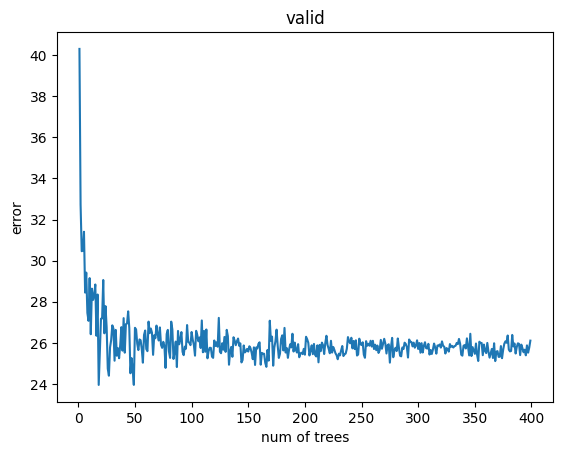

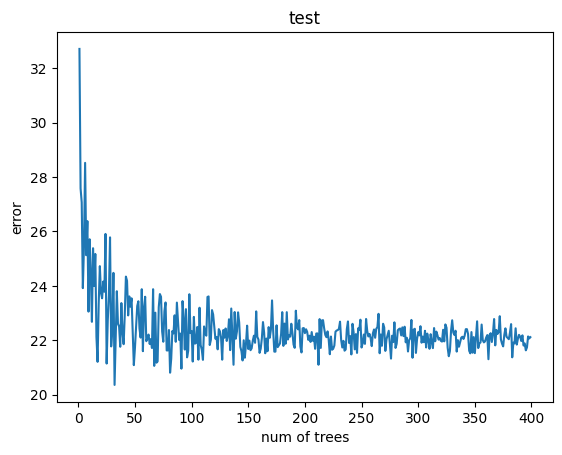

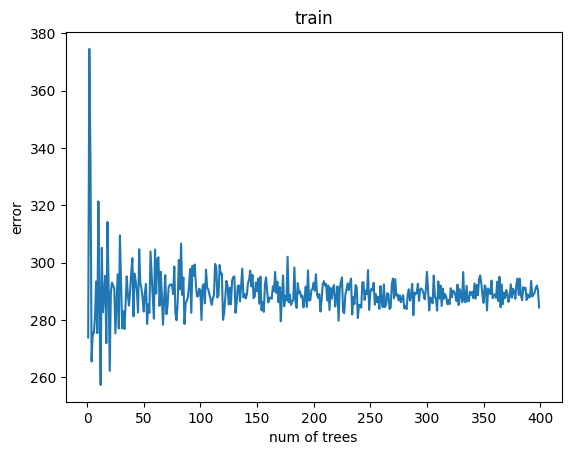

In [305]:
def ensembleCreator(k):
    return RandomForestRegressor(n_estimators=k)
best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw = predict(ensembleCreator, 400)
draw(best_k, min_e, x_valid_to_draw, y_valid_to_draw, x_test_to_draw, y_test_to_draw, x_train_to_draw, y_train_to_draw, 'num of trees')